# Using Moving Avg Prediction

In [2]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


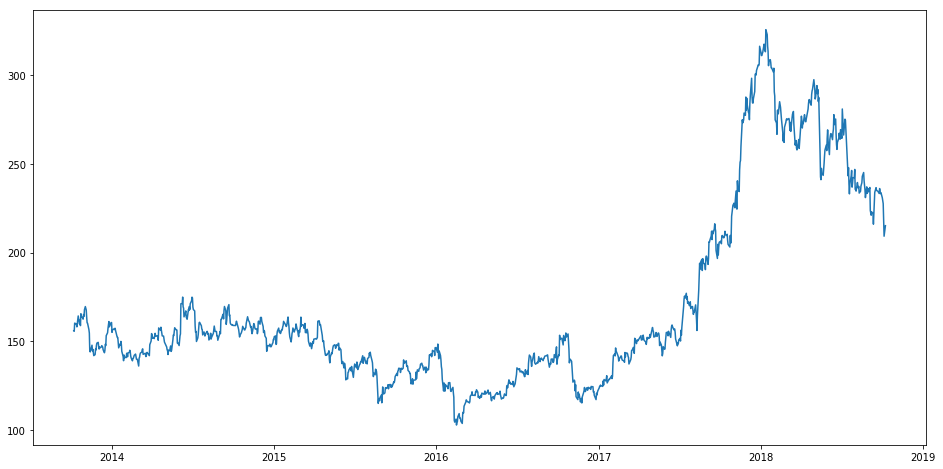

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [12]:
data = df.sort_index(ascending=True, axis=0)

In [14]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

In [15]:
#splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

In [16]:
new_data.shape, train.shape, valid.shape
((1235, 2), (987, 2), (248, 2))

((1235, 2), (987, 2), (248, 2))

In [17]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2013-10-08 00:00:00'),
 Timestamp('2017-10-06 00:00:00'),
 Timestamp('2017-10-09 00:00:00'),
 Timestamp('2018-10-08 00:00:00'))

In [21]:
preds = [] #for storing prediction

for i in range(0,248):
    a = train[len(train)-248+i:]['Close'].sum() + sum(preds)
    b = a/248
    
    preds.append(b)

In [24]:
valid['Predictions'] = preds

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


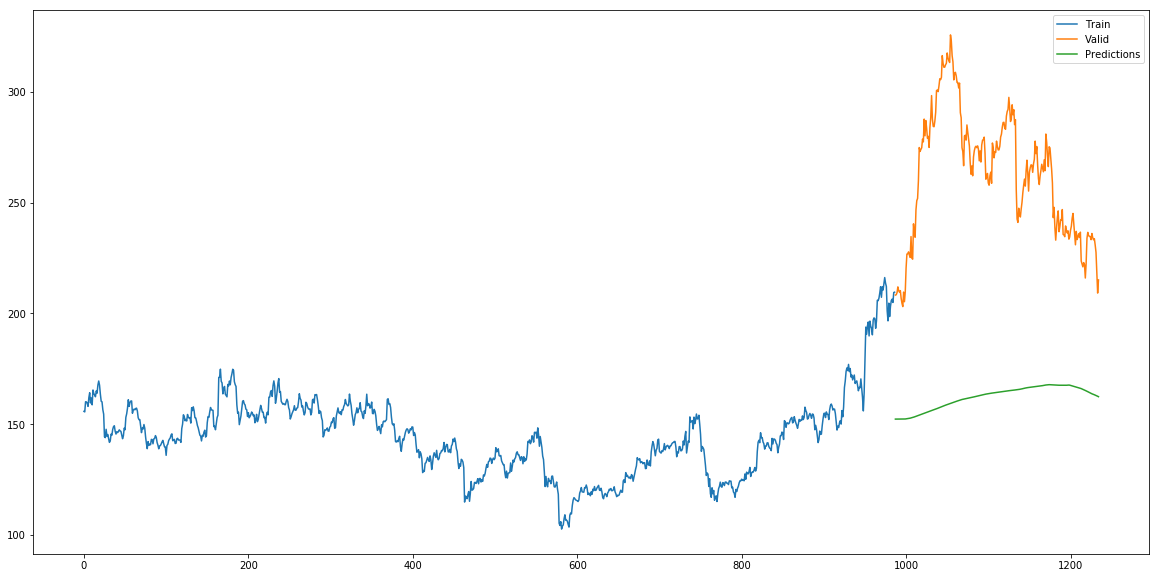

In [40]:
plt.plot(train['Close'], label = 'Train')
plt.plot(valid['Close'], label = 'Valid')
plt.plot(valid['Predictions'])
plt.legend(loc='best')

As seen above, the predictions are nowhere close to the actual validation values.

# Using LSTM

In [41]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM

In [94]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)



In [81]:

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

In [45]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [84]:
x_train, y_train = [], []
scaled_data.shape

(1235, 1)

In [85]:
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    

In [86]:
x_train,y_train= np.array(x_train), np.array(y_train)

In [87]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [88]:
x_train.shape

(927, 60, 1)

In [89]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [90]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1)

Epoch 1/1
927/927 [==============================] - 66s 71ms/step - loss: 9.9288e-04


In [91]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [92]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

8.601782760290616

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


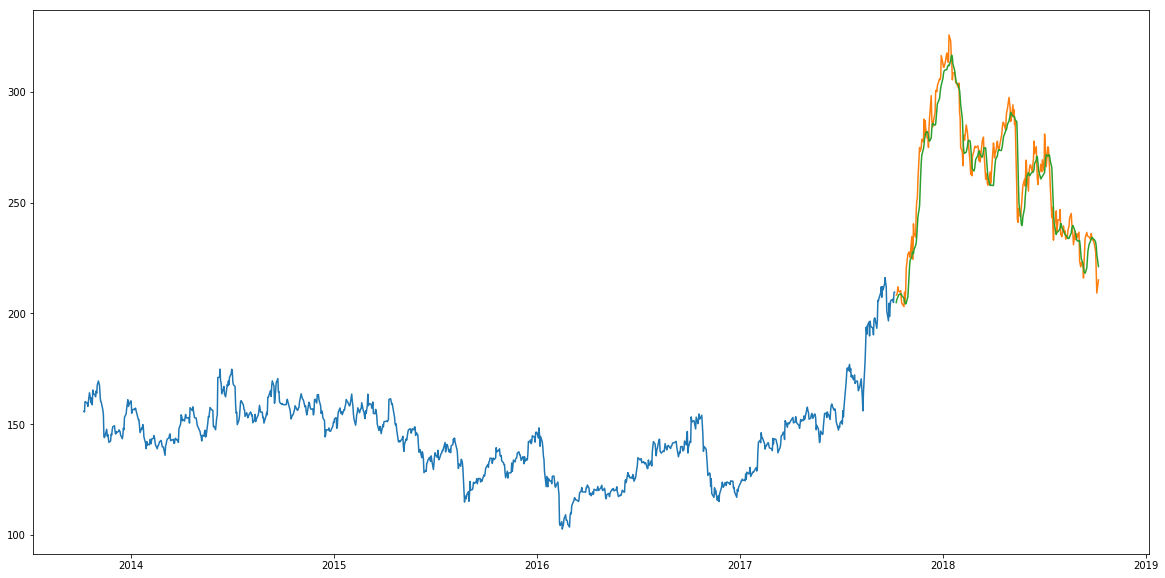

In [93]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

You can see near perfect prediction using LSTM